<a href="https://colab.research.google.com/github/Chaeran/2023DLTeamProject/blob/main/FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip -q /content/phone_using.v1i.voc.zip

In [23]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [38]:
from IPython.utils import dir2
%cd /content/
from torch.jit import annotate
import os
import random
import numpy as np
import shutil

Dir = r'test'
fileEx = r'.xml'
annot_list = [file for file in os.listdir(Dir) if file.endswith(fileEx)]
annot_list.sort()
for annot in annot_list:
  shutil.move("/content/test/"+annot, '/content/test_annotations/'+annot)

fileEx2 = r'.jpg'
img_list = [file for file in os.listdir(Dir) if file.endswith(fileEx2)]
img_list.sort()
for img in img_list:
  shutil.move("/content/test/"+img, '/content/test_images/'+img)

Dir = r'train'
fileEx = r'.xml'
annot_list = [file for file in os.listdir(Dir) if file.endswith(fileEx)]
annot_list.sort()
#len(annot_list)
#print(annot_list[:10])
for annot in annot_list:
  shutil.move("/content/train/"+annot, '/content/annotations/'+annot)

fileEx2 = r'.jpg'
img_list = [file for file in os.listdir(Dir) if file.endswith(fileEx2)]
img_list.sort()
#print(img_list[:10])
for img in img_list:
  shutil.move("/content/train/"+img, '/content/images/'+img)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

/content
[]
198
198
29
29


In [24]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [81]:
#바운딩 박스 치기
def generate_box(obj):  # xml 파일의 좌표위치 반환

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

adjust_label = 1

def generate_label(obj):
    if obj.find('name').text == "phone_calling":
        return 1 + adjust_label
    elif obj.find('name').text == "phone_texting":
        return 2 + adjust_label
    return 0 + adjust_label # holding

def generate_target(file):
#generate_box와 generate_label을 각각 호출하여 반환된 값을 딕셔너리에 저장해 반환
    with open(file) as f:
        data = f.read()
        #html.parser이용해 annot 파일에 있는 내용 불러와 타겟의 bbox와 라벨 추출
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

def plot_image_from_output(img, annotation):

    img = img.cpu().permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)


    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx].cpu()

        if annotation['labels'][idx] == 1 : # holding : 빨강
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        elif annotation['labels'][idx] == 2 : #통화 : 주황

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        else:    #문자 : 파랑
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')


        ax.add_patch(rect)

    plt.show()

In [108]:
class PhoneDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
#### img, annot로 분리를 안해줘서 문제 생길 수도

    def __getitem__(self, idx): #special method
        # load images
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = PhoneDataset(data_transform, 'images/')
test_dataset = PhoneDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=25, collate_fn=collate_fn)

In [83]:
# Transfer Learning
def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [84]:
model = get_model_instance_segmentation(4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [85]:
torch.cuda.is_available() #GPU 사용가능 여

True

In [87]:
#학습
num_epochs = 20
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [88]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------
epoch : 1, Loss : 13.321596145629883, time : 36.272411584854126
epoch : 2, Loss : 9.30978012084961, time : 37.94536256790161
epoch : 3, Loss : 7.903264045715332, time : 39.38461899757385
epoch : 4, Loss : 6.327232360839844, time : 39.62590575218201
epoch : 5, Loss : 5.490447521209717, time : 39.20453214645386
epoch : 6, Loss : 5.072338581085205, time : 39.347074031829834
epoch : 7, Loss : 4.8321990966796875, time : 39.49744367599487
epoch : 8, Loss : 4.029348373413086, time : 39.42703723907471
epoch : 9, Loss : 4.211564540863037, time : 39.37690019607544
epoch : 10, Loss : 4.819323539733887, time : 39.34859347343445
epoch : 11, Loss : 3.669949531555176, time : 39.31145358085632
epoch : 12, Loss : 3.292963981628418, time : 39.321903467178345
epoch : 13, Loss : 3.2492048740386963, time : 39.33585000038147
epoch : 14, Loss : 2.7681453227996826, time : 39.31137228012085
epoch : 15, Loss : 2.7079434394836426, time : 39.373886108398

In [89]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [90]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

<All keys matched successfully>

In [110]:
# 예측
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [111]:
with torch.no_grad():
    # 테스트셋 배치사이즈= 25
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[355.1946, 329.5953, 454.7139, 501.1707]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9133], device='cuda:0')}, {'boxes': tensor([[356.5614, 331.0805, 455.9830, 502.2514]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9321], device='cuda:0')}, {'boxes': tensor([[327.2385, 385.1070, 420.6453, 564.9133]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9374], device='cuda:0')}, {'boxes': tensor([[291.3691, 271.4933, 360.5070, 407.1447]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9748], device='cuda:0')}, {'boxes': tensor([[251.0874, 341.4509, 356.8973, 557.8323]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9402], device='cuda:0')}, {'boxes': tensor([[360.8780, 266.8244, 432.4674, 437.7747]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9634], device='cuda:0')}, {'boxes':

Target :  tensor([1])


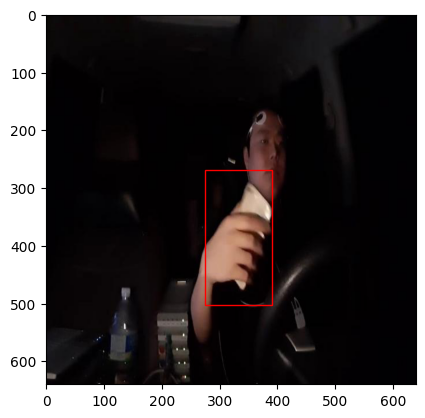

Prediction :  tensor([1], device='cuda:0')


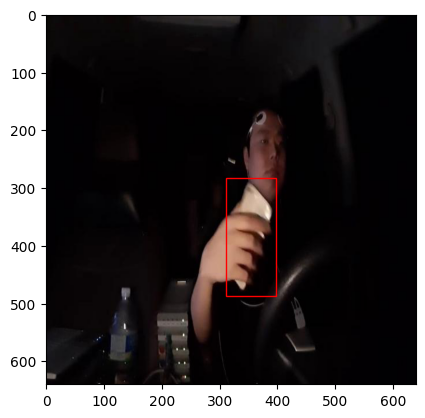

In [135]:
_idx = 15
#print(annotations[0])
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])

In [94]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 15/15 [00:02<00:00,  5.35it/s]


In [95]:
# mAP, AP 계산
%cd /content/
import utils_ObjectDetection as utils

/content


In [96]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.7241666702429453
AP : tensor([0.6000, 0.9475, 0.6250], dtype=torch.float64)
